## Assignment 2: Time Series Forecasting

### Chia-Hao Lo, 1907385, Version 05

#### Follow detail instructions in the assignment specification and use these heading for implementation and discussion

### 1. Paper evaluation

(Candanedo, LM, Feldheim, V & Deramaix, D 2017, 'Data driven prediction models of energy use of appliances in a low-energy house', Energy and buildings, vol. 140, pp. 81-97.)
https://myuni.adelaide.edu.au/courses/105130/files/16388685?wrap=1

While the paper successfully explores supervised learning methods—namely Linear Regression, SVM, Random Forest, and GBM—to predict energy consumption at specific time points, its focus is limited to instantaneous prediction rather than true time-series forecasting. In contrast, our forecasting task is good for predict future appliance energy usage based on both past values (autoregressive behavior) and multivariate features like weather and time.

The paper’s approach does not incorporate temporal modeling techniques like ARIMA or LSTM, which are important for sequence-aware predictions. As a result, its models cannot account for seasonality, autocorrelation, or temporal patterns, making them less suitable for forecasting into the future. Moreover, the overfitting of GBM in the paper underscores a risk of relying solely on complex models without cross-validation or regularization for generalization.

In our case, methods like LSTM and ARIMA are more appropriate because they can capture temporal dependencies, though I also tested traditional models for comparison. Techniques from the paper, like feature engineering for time-of-day or weather are still valuable and can be adapted to enhance model input. However, their supervised models, being time-agnostic, are limited in predicting future energy demand accurately over time horizons beyond immediate time steps.


### 2. Analyse and visualise the Time Series

#### 2.1 Environment

In [1]:
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
random.seed(2025)

#### 2.2 Reading data

In [2]:
df = pd.read_csv('./data/energydata_complete.csv')
df_d = df.copy()
print(df_d.shape)
df_d.head()

(14941, 29)


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,14/02/2016 0:00,50,10,21.790000,39.900000,20.100000,40.79,21.39,40.59,19.2,...,18.0,41.933333,2.90,732.90,98.000000,2.000000,31.0,2.6,48.320978,48.320978
1,14/02/2016 0:10,50,0,21.790000,39.900000,20.033333,40.73,21.39,40.59,19.2,...,18.0,42.133333,2.87,732.95,98.166667,2.166667,28.5,2.6,33.339359,33.339359
2,14/02/2016 0:20,60,10,21.700000,39.933333,19.890000,40.79,21.39,40.53,19.2,...,18.0,42.360000,2.83,733.00,98.333333,2.333333,26.0,2.6,8.168115,8.168115
3,14/02/2016 0:30,40,0,21.633333,39.860000,19.890000,40.79,21.39,40.59,19.2,...,18.0,42.633333,2.80,733.05,98.500000,2.500000,23.5,2.6,16.197509,16.197509
4,14/02/2016 0:40,60,10,21.600000,39.900000,19.790000,40.79,21.39,40.59,19.1,...,18.0,42.860000,2.77,733.10,98.666667,2.666667,21.0,2.6,12.559574,12.559574


In [3]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14941 entries, 0 to 14940
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         14941 non-null  object 
 1   Appliances   14941 non-null  int64  
 2   lights       14941 non-null  int64  
 3   T1           14941 non-null  float64
 4   RH_1         14941 non-null  float64
 5   T2           14941 non-null  float64
 6   RH_2         14941 non-null  float64
 7   T3           14941 non-null  float64
 8   RH_3         14941 non-null  float64
 9   T4           14941 non-null  float64
 10  RH_4         14941 non-null  float64
 11  T5           14941 non-null  float64
 12  RH_5         14941 non-null  float64
 13  T6           14941 non-null  float64
 14  RH_6         14941 non-null  float64
 15  T7           14941 non-null  float64
 16  RH_7         14941 non-null  float64
 17  T8           14941 non-null  float64
 18  RH_8         14941 non-null  float64
 19  T9  

In [4]:
df_d.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,...,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000,14941.000000
mean,96.747206,3.235393,22.030776,39.418672,20.519140,39.935868,22.770465,38.046386,21.425985,37.701517,...,20.143157,40.454742,8.182569,755.575393,77.559434,3.671039,37.922696,4.055227,25.047636,25.047636
std,97.297111,7.296554,1.469766,3.880367,2.322643,4.328421,1.897689,2.530175,1.843571,3.701348,...,1.782497,3.566295,5.464633,6.613943,15.720014,2.218070,11.415145,4.220123,14.436670,14.436670
min,10.000000,0.000000,18.600000,27.023333,16.200000,20.463333,19.100000,28.766667,17.290000,27.660000,...,17.260000,29.166667,-4.400000,732.900000,24.000000,0.000000,1.000000,-6.100000,0.005322,0.005322
25%,50.000000,0.000000,21.000000,36.790000,18.890000,37.260000,21.390000,36.363333,20.100000,34.900000,...,18.571429,38.030000,4.230000,751.200000,66.666667,2.000000,29.000000,0.983000,12.593007,12.593007
50%,60.000000,0.000000,21.823333,38.790000,20.000000,39.900000,22.566667,37.760000,21.166667,37.200000,...,20.000000,39.863333,7.630000,755.700000,80.833333,3.166667,40.000000,3.600000,25.120708,25.120708
75%,100.000000,0.000000,22.890000,41.400000,21.830000,42.700000,24.033333,39.260000,22.738571,39.700000,...,20.890000,42.530000,11.400000,760.200000,90.833333,5.000000,40.000000,6.900000,37.454428,37.454428
max,900.000000,50.000000,26.260000,57.496667,29.856667,56.026667,29.236000,47.693333,26.200000,50.760000,...,24.500000,51.536000,26.100000,772.300000,100.000000,13.000000,66.000000,15.500000,49.992758,49.992758


Transfrom the date column to datetime format. This can help us ensuring  proper time-based operation.

In [5]:
df_d['date'] = pd.to_datetime(df_d['date'])
df_d.set_index('date', inplace=True)

/var/folders/0l/qgn1vqn15c3gw9rx0_bhcwq40000gn/T/ipykernel_17918/1917366405.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_d['date'] = pd.to_datetime(df_d['date'])


#### 2.3 Missing data checking

In [6]:
df_d.isna().sum()


Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

Here we make sure there is no missing value in the dataset.

#### 2.4 Data Analysis and visualize the data

We will analyse the data and do the visualization to understand it. From here we analysis general data and also LSTM, ARIMA. These analyzes suggest how can we deal with building models and preprocessing step.

In [7]:
df_app = df_d['Appliances']

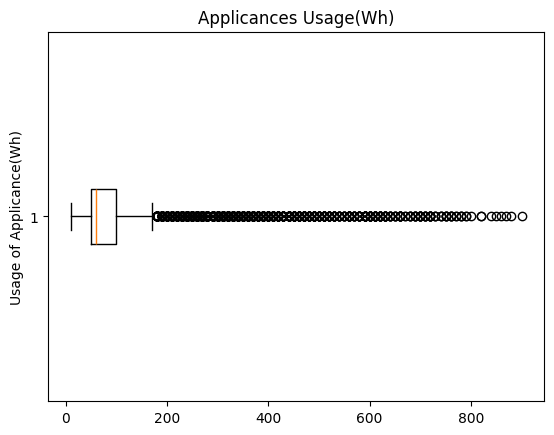

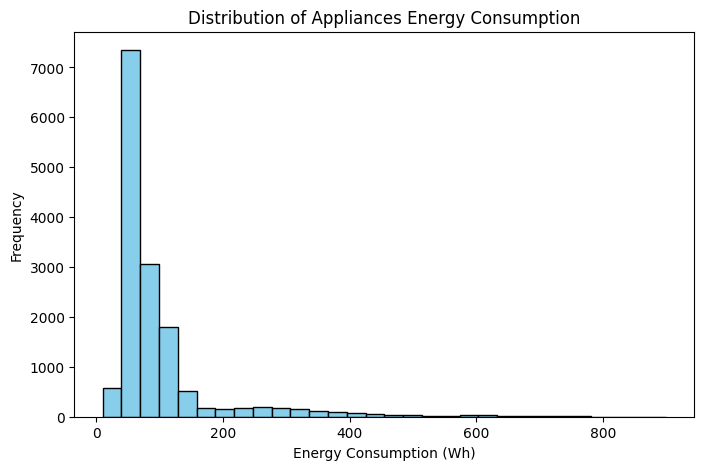

count    14941.000000
mean        96.747206
std         97.297111
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max        900.000000
Name: Appliances, dtype: float64

In [8]:
plt.boxplot(df_app, vert=False)
plt.title('Applicances Usage(Wh)')
plt.ylabel('Usage of Applicance(Wh)')

plt.figure(figsize=(8, 5))
plt.hist(df_d['Appliances'], bins=30, color='skyblue', edgecolor ='black')
plt.title("Distribution of Appliances Energy Consumption")
plt.xlabel("Energy Consumption (Wh)")
plt.ylabel("Frequency")
plt.show()

df_app.describe()

From the dataset we can see that the upper and lower quantil of usage in "Applicances" column is 50 and 100 respectively and also the data is not normally distributed. There are many outliers and this is right-skewed data. Later we will make it normally distributed and see the pattern.

Text(0, 0.5, 'Applicances (Wh)')

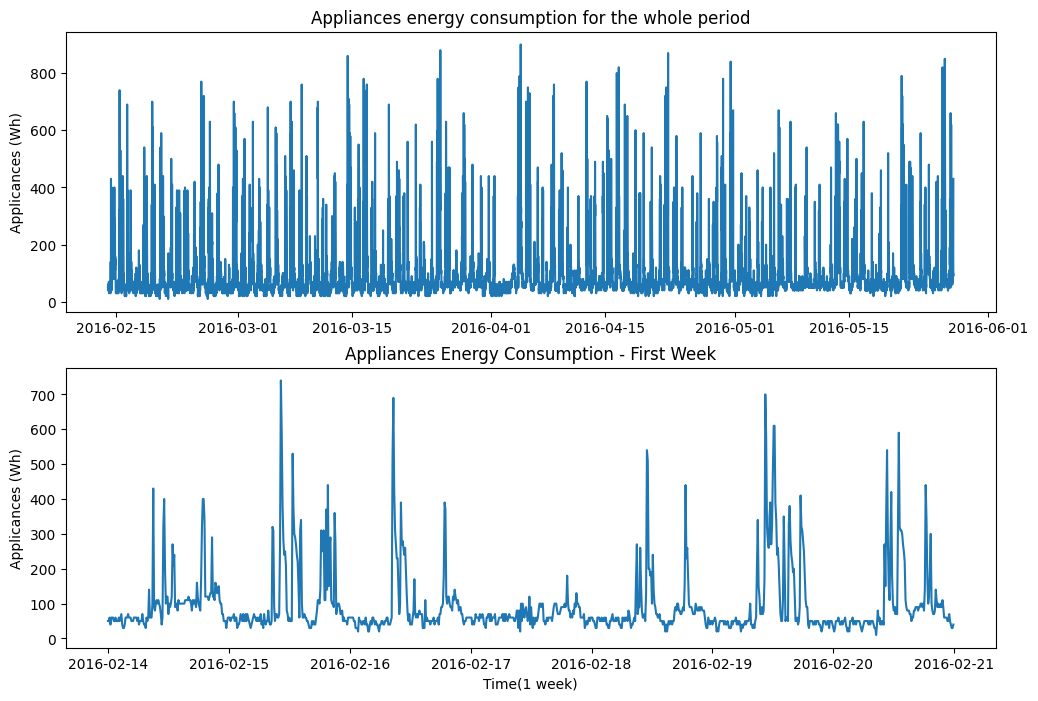

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# Plot for the whole period
ax[0].plot(df_d.index, df_app)
ax[0].set_title('Appliances energy consumption for the whole period')
ax[0].set_ylabel('Applicances (Wh)')
# Plot for the first week
start_date = '2016-02-14'
end_date = '2016-02-20'
df_w1 = df_d.loc[start_date:end_date]

ax[1].plot(df_w1.index, df_w1['Appliances'])
ax[1].set_title('Appliances Energy Consumption - First Week')
ax[1].set_xlabel('Time(1 week)')
ax[1].set_ylabel('Applicances (Wh)')

In the paper it mentioned about the energy consumption shows a high variability. From the plot we can see that both time period plots show large fluctuations over time, frequent and significant spikes and dips. This means there might be a lot of noise and fluctuations, it makes modeling and prediction more challenging.

In [10]:
df_app.index = df_d.index
df_daily = df_app.resample('D').sum()
df_daily.head()

date
2016-02-14    14750
2016-02-15    16950
2016-02-16    13420
2016-02-17     9620
2016-02-18    12060
Freq: D, Name: Appliances, dtype: int64

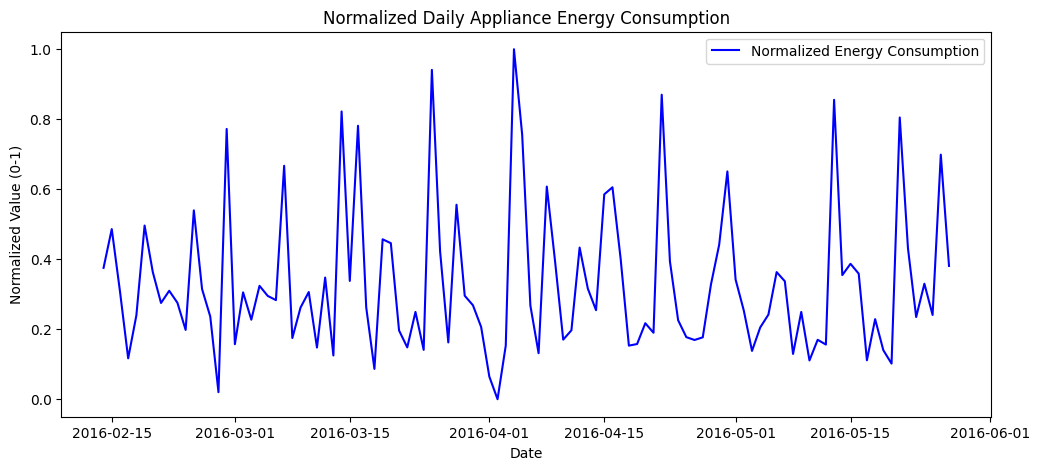

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_daily_scaled = scaler.fit_transform(df_daily.values.reshape(-1, 1))

df_daily_scaled = pd.DataFrame(df_daily_scaled, index=df_daily.index, columns=['Appliances'])

plt.figure(figsize=(12, 5))
plt.plot(df_daily_scaled, label='Normalized Energy Consumption', color='blue')
plt.xlabel("Date")
plt.ylabel("Normalized Value (0-1)")
plt.title("Normalized Daily Appliance Energy Consumption")
plt.legend()
plt.show()

Since we cannot get the seasonal variations from the data, we tried to normalize the data and catched the pattern from it. We could see that there are clear peaks and lows, the sharp spikes indicated high-energy consumption events. The overall pattern seems irregular but it shows potential weekly cycles. Time-series models can learn the patterns and improve forecasting.

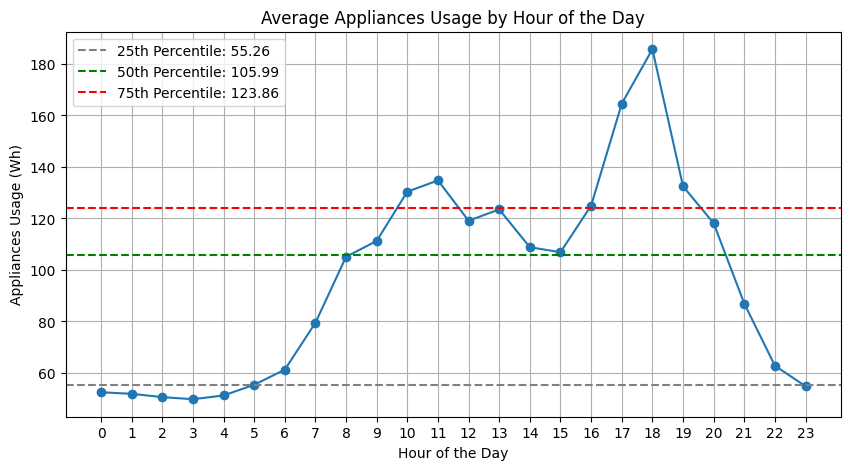

In [12]:
df_d['hour'] = df_d.index.hour

df_hourly = df_d.groupby('hour')['Appliances'].mean()

q3_hours = df_hourly.quantile(0.75)
q2_hours = df_hourly.quantile(0.5)
q1_hours = df_hourly.quantile(0.25)

plt.figure(figsize=(10, 5))
plt.plot(df_hourly.index, df_hourly.values, marker='o', linestyle='-')

plt.axhline(q1_hours, color='grey', linestyle='--', label=f'25th Percentile: {q1_hours:.2f}')
plt.axhline(q2_hours, color='green', linestyle='--', label=f'50th Percentile: {q2_hours:.2f}')
plt.axhline(q3_hours, color='red', linestyle='--', label=f'75th Percentile: {q3_hours:.2f}')

plt.title("Average Appliances Usage by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Appliances Usage (Wh)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.show()

From the graph we could see that at 23, 0-5 of the energy consumption is the lowest. By the contrast, at 10-11, 13, 16-19 of the energy consumption is the peak time of a day.

#### 2.4.1 Data analysis for ARIMA 

#### ADF test

In [13]:
result = adfuller(df_d['Appliances'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value:.4f}')

ADF Statistic: -17.9167
p-value: 0.0000
Critical Values:
   1%: -3.4308
   5%: -2.8617
   10%: -2.5669


As we can see, the p-value shows 0.0000, this is the reason that we can assume the data is stationary. For first order, we may use 0 due to the p-value is nearly 0.

#### ACF & PACF

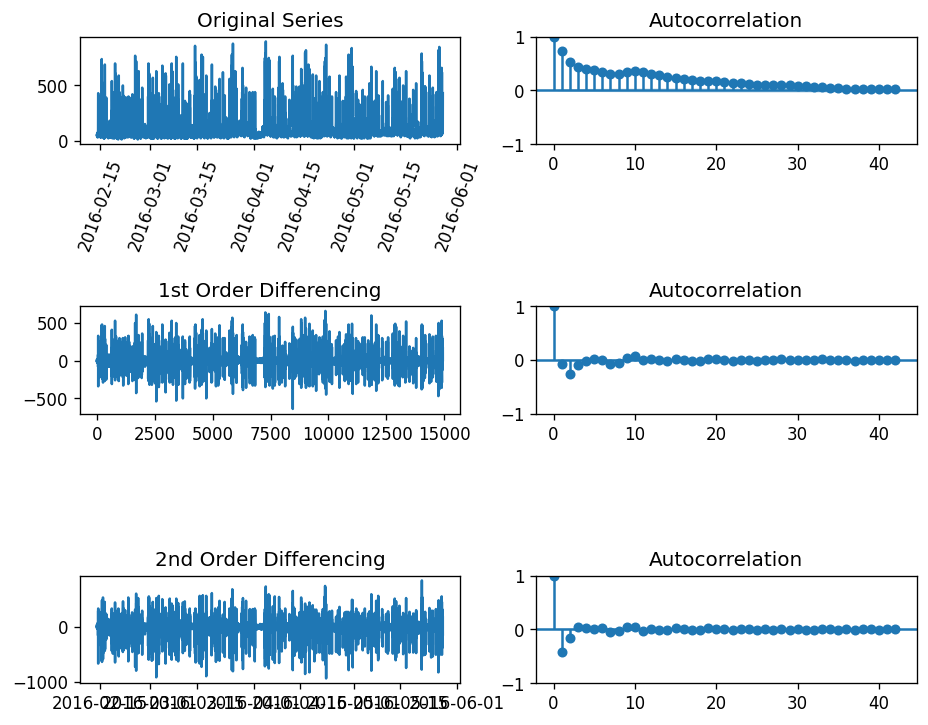

In [14]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df_d['Appliances']); axes[0, 0].set_title('Original Series')
axes[0, 0].tick_params(axis='x', rotation=70)
plot_acf(df_d['Appliances'], ax=axes[0, 1])

axes[1, 0].plot(df['Appliances'].diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_d['Appliances'].diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(df_d['Appliances'].diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Appliances'].diff().diff().dropna(), ax=axes[2, 1])

fig.subplots_adjust(hspace = 1.5)
plt.show()

From ADF test we get p-value is nearly 0. Here we can check if we need to use original series. From the result of 1st order, we can see that it improves a lot and we can avoid the risk of under-differencing. For 2nd order, it doesn't improve much so we decide to use 1st order differencing. Thus we decided to use 1st order differencing for d.

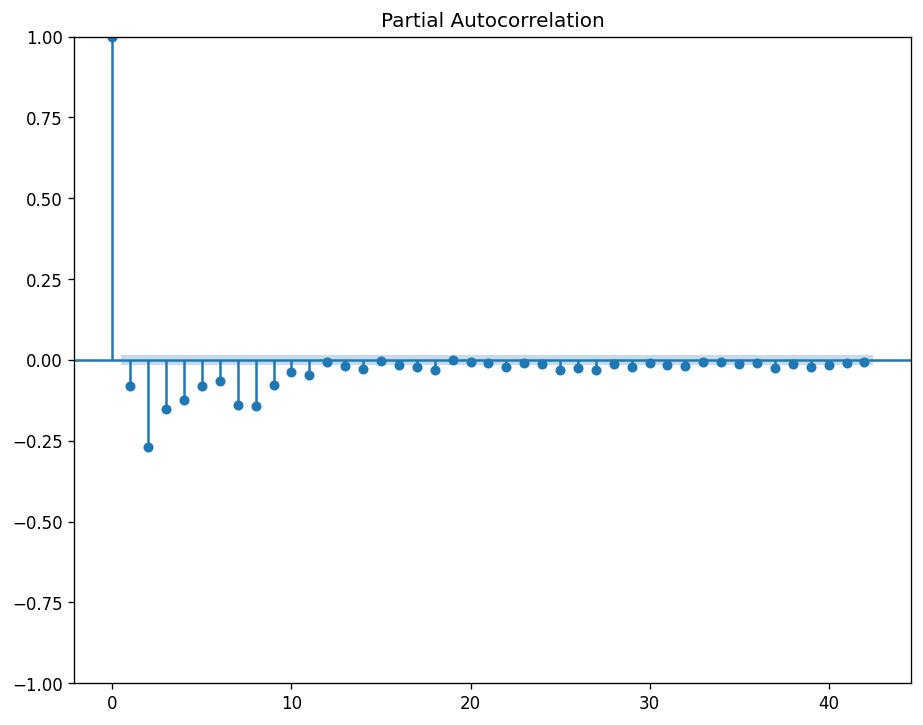

In [15]:
fig, ax = plt.subplots(1, sharex=False)
ax.set(ylim=(0,5))
# 1st Differencing
plot_pacf(df_d['Appliances'].diff().dropna(), ax=ax)

plt.show()

From the PACF plot we can see that after 10 there is no significant spikes, thus we decided to use 10th lag for P. Since we selected 10th lag as the autoregressive order, since lags beyond that contribute little to no predictive power.

<Figure size 1200x600 with 0 Axes>

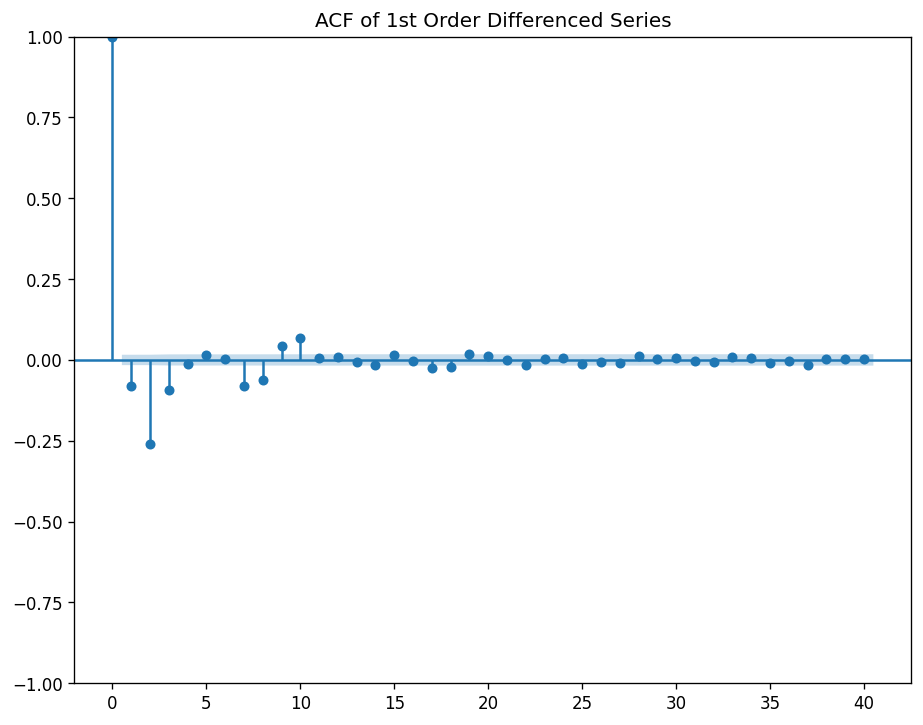

In [16]:
plt.figure(figsize=(10, 5))
plot_acf(df_d['Appliances'].diff().dropna(), lags=40)
plt.title('ACF of 1st Order Differenced Series')
plt.show()

After 3rd lag, there is no much difference from other legs. Thus we decided to use 3rd lag. Other lags falls below the significance level.

#### 2.4.2 Seasonal pattern
Since there is no obvious pattern and seasonality from day interval, let us check with 1-hour to see if there is a specific pattern. This can give us a forsight to decide with interval for model building.

In [17]:
df_hourly = df_d['Appliances'].resample('H').sum()
display(df_hourly)

/var/folders/0l/qgn1vqn15c3gw9rx0_bhcwq40000gn/T/ipykernel_17918/2070734172.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_d['Appliances'].resample('H').sum()


date
2016-02-14 00:00:00     320
2016-02-14 01:00:00     320
2016-02-14 02:00:00     330
2016-02-14 03:00:00     280
2016-02-14 04:00:00     350
                       ... 
2016-05-27 14:00:00     610
2016-05-27 15:00:00     460
2016-05-27 16:00:00     810
2016-05-27 17:00:00    1080
2016-05-27 18:00:00     430
Freq: h, Name: Appliances, Length: 2491, dtype: int64

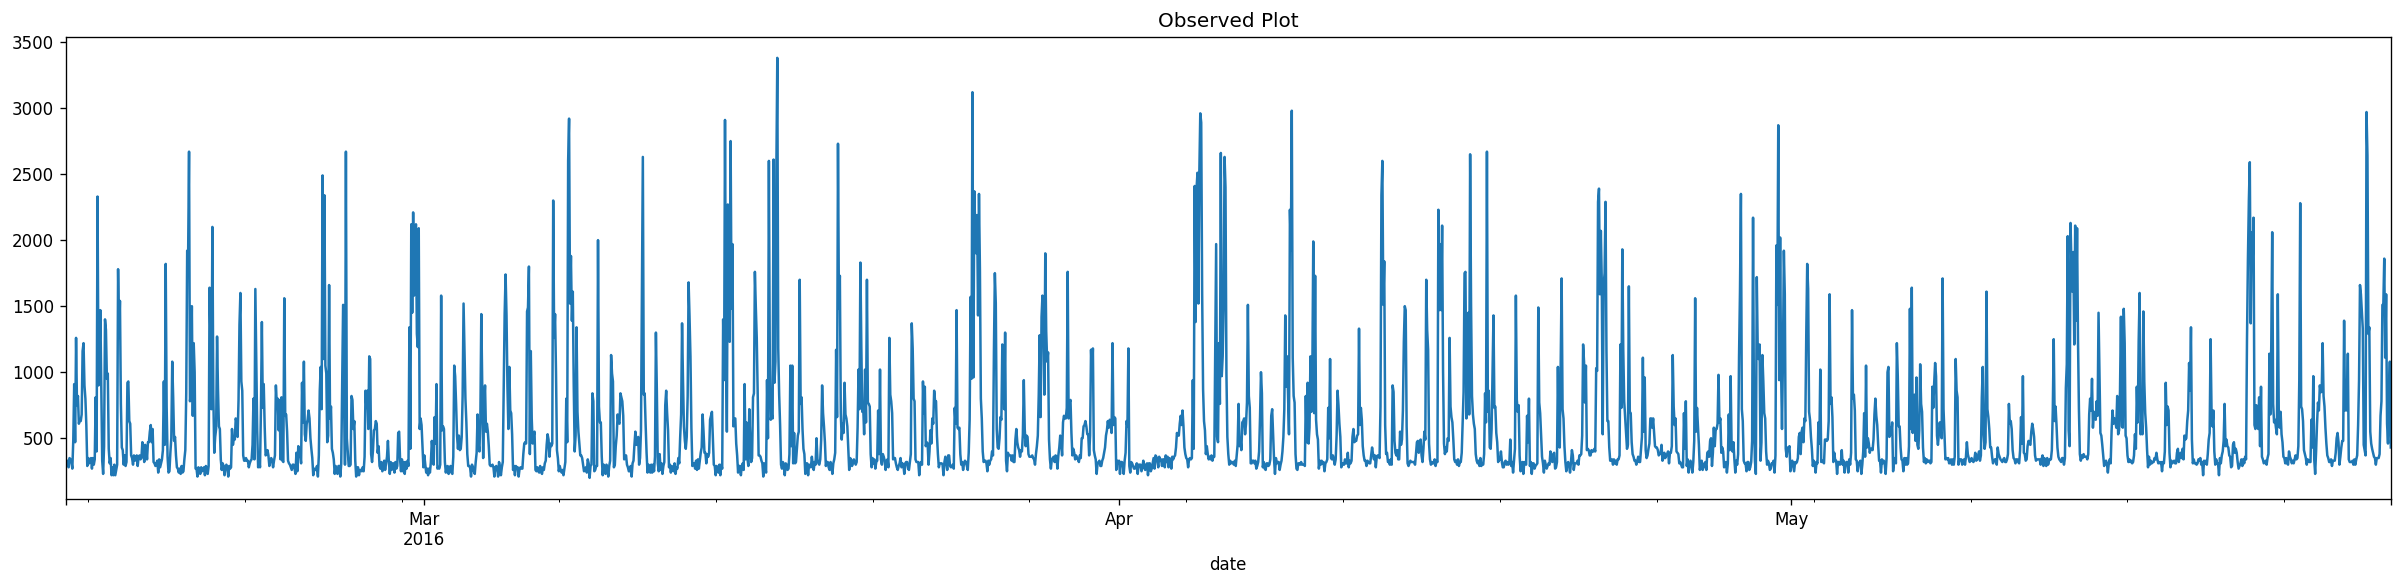

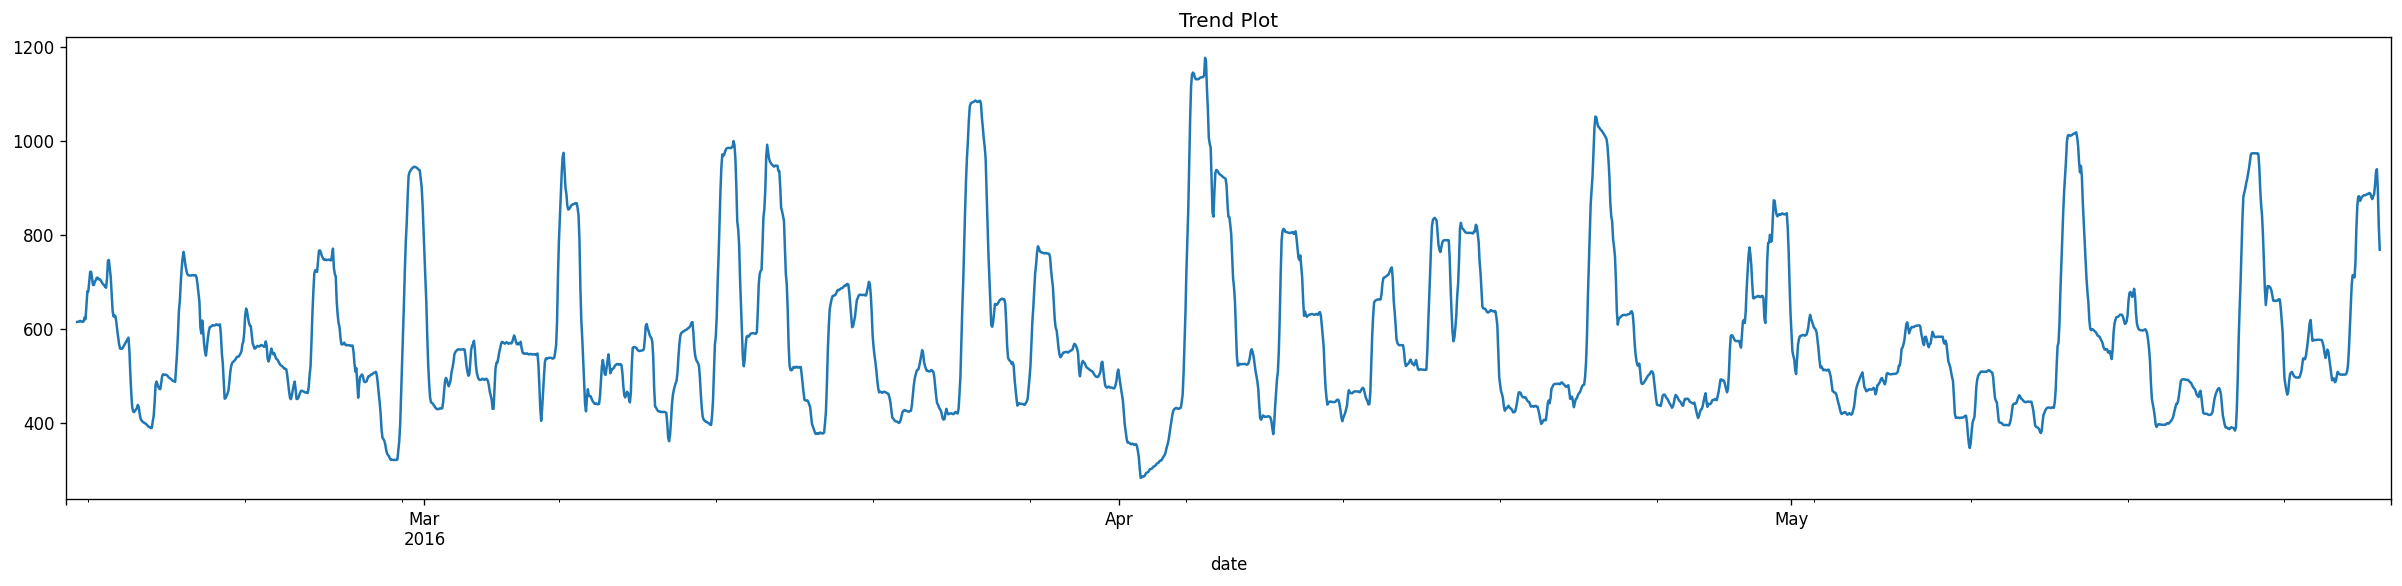

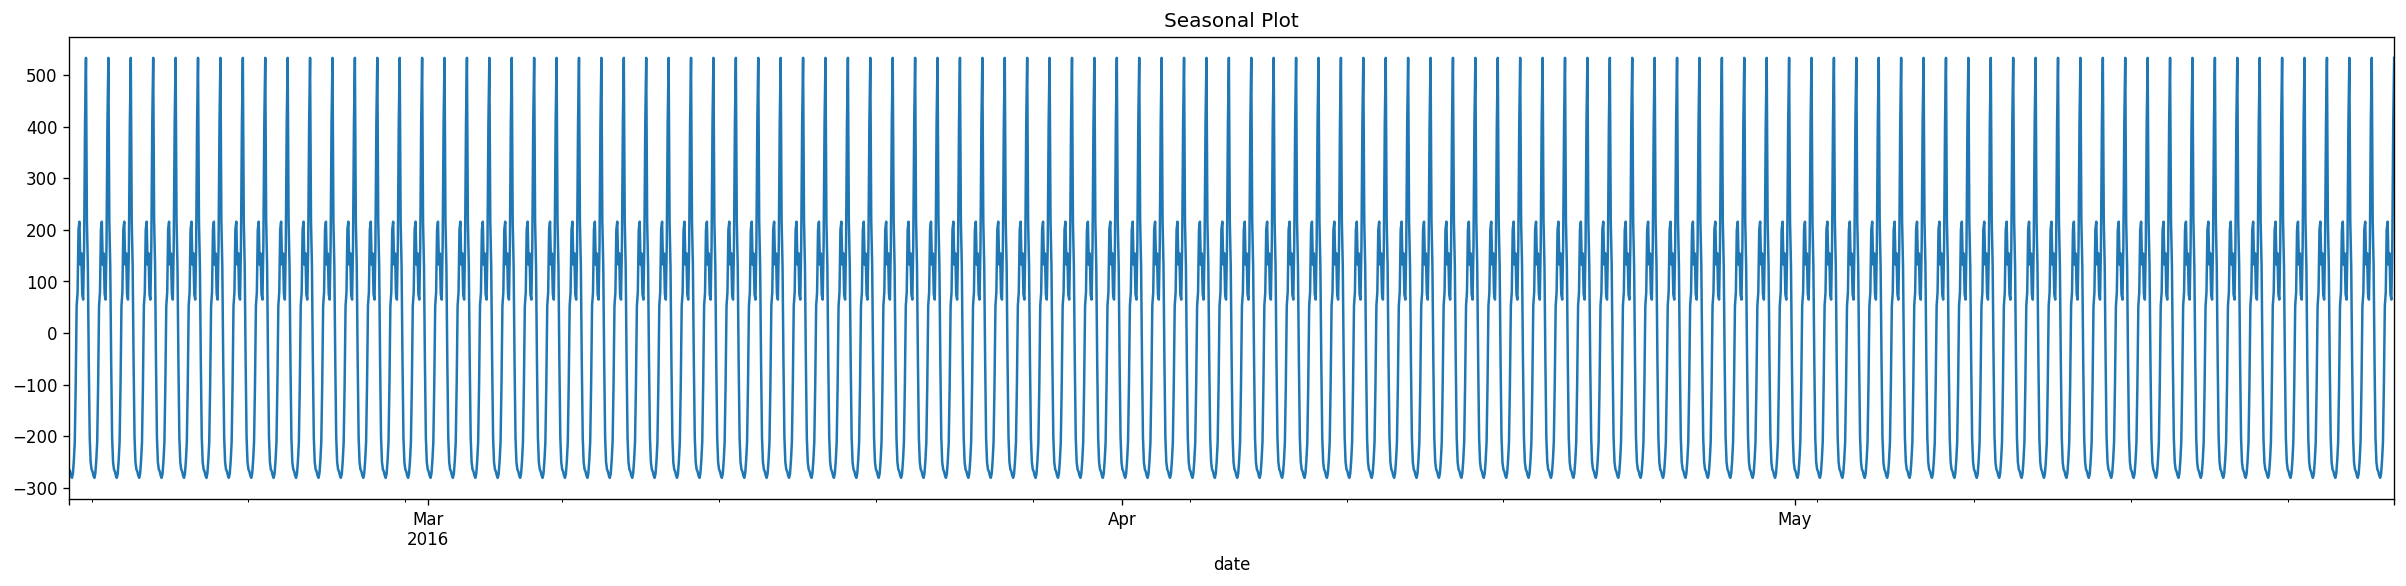

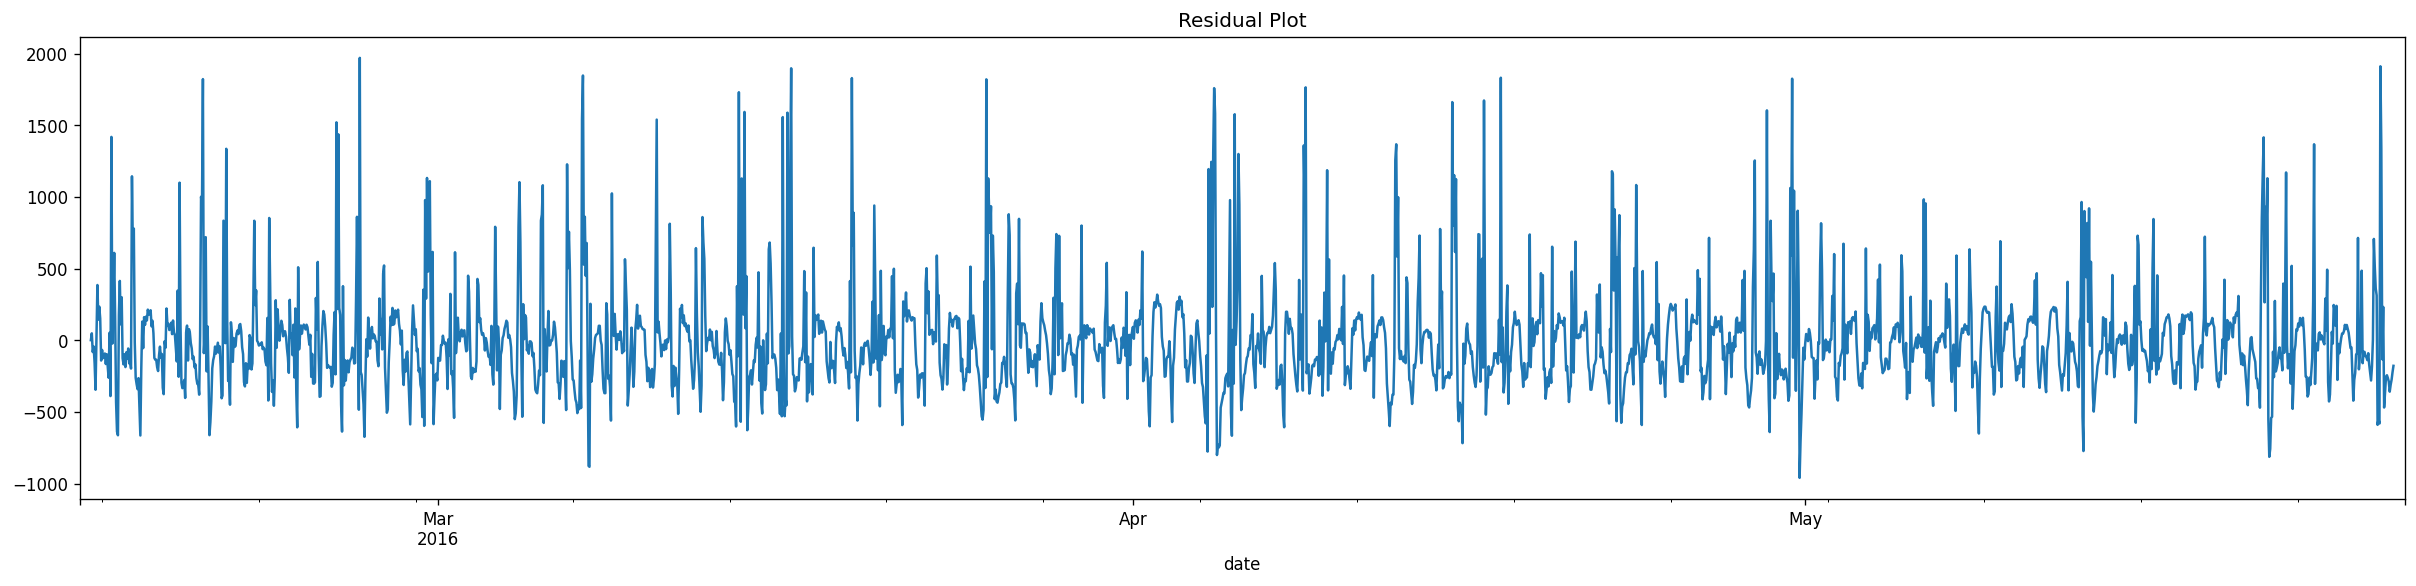

In [18]:
result = seasonal_decompose(df_hourly, model='additive', period=24)
plt.figure(figsize=(25, 5))
plt.title('Observed Plot')
result.observed.plot()

plt.figure(figsize=(25, 5))
plt.title('Trend Plot')
result.trend.plot()
plt.show()

plt.figure(figsize=(25, 5))
plt.title('Seasonal Plot')
result.seasonal.plot()
plt.show()

plt.figure(figsize=(25, 5))
plt.title('Residual Plot')
result.resid.plot()
plt.show()

From the plots we still cannot observe any perticular patterns, this means the data is not steady and contains many outliers.

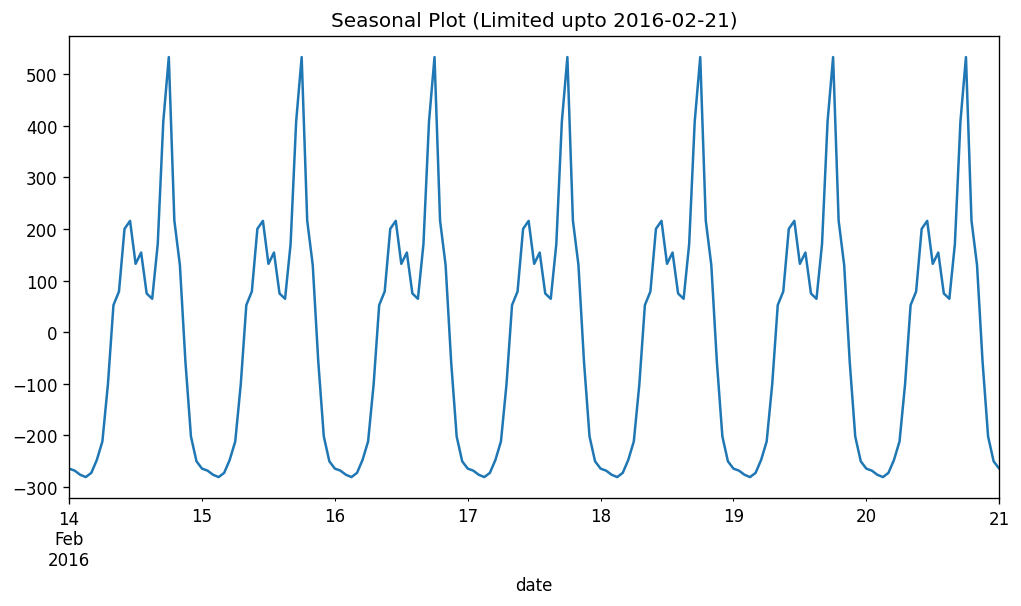

In [19]:
plt.figure(figsize=(10, 5))
plt.title('Seasonal Plot (Limited upto 2016-02-21)')
result.seasonal.plot()
plt.xlim('2016-02-14', '2016-02-21')
plt.show()

After we zoomed in the first week of data, we can observe a clear pattern that in the morning shows lower energy comsumption. On the other hand, from noon to night the comsumption of energy go higher. It shows people was sleeping at the midnight to the morning so the energy of comsumption is really low.

### 3. Pre-process the data

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
# Function to convert a time series dataset into sequences for LSTM input
def to_sequence(data, seq_len=30, is_univariate=False):
    X, y = [], []
    for i in range(seq_len, len(data)):
        if is_univariate:
            X.append(data[i-seq_len:i, 0])      
            y.append(data[i, 0])               
        else:
            X.append(data[i-seq_len:i, :-1])    
            y.append(data[i, -1])              
    return np.array(X), np.array(y)

In [22]:
df_implement = df.copy()
df_implement['date'] = pd.to_datetime(df_implement['date'])
df_implement['mm'] = df_implement['date'].dt.hour*60 + df_implement['date'].dt.minute

# Define the columns to be used for the LSTM model
X = ['mm', 'T6', 'T_out', 'T2', 'Windspeed', 'lights', 'RH_1', 'T3', 'T1', 'RH_3', 'T7', 'T8', 'RH_4', 'Tdewpoint', 'T4', 'T9', 'T5', 'RH_5']
y = ['Appliances']

all_columns = X + y
df_implement = df_implement[all_columns].copy()

split_ratio = 0.75
split_index = int(len(df_implement) * split_ratio)
# Multivariate time series data
multivariate_train = df_implement[:split_index]
multivariate_test = df_implement[split_index:]

val_ratio = 0.2
val_index = int(len(multivariate_train) * (1 - val_ratio))

multivariate_val = multivariate_train[val_index:]
multivariate_train = multivariate_train[:val_index]

scaler = StandardScaler()
scaler.fit(multivariate_train)

scaled_train_multi = pd.DataFrame(scaler.transform(multivariate_train), columns=multivariate_train.columns)
scaled_val_multi = pd.DataFrame(scaler.transform(multivariate_val), columns=multivariate_val.columns)
scaled_test_multi = pd.DataFrame(scaler.transform(multivariate_test), columns=multivariate_test.columns)

scaled_multi_train_X, scaled_multi_train_y = to_sequence(scaled_train_multi.values, 2, is_univariate=False)
scaled_multi_val_X, scaled_multi_val_y = to_sequence(scaled_val_multi.values, 2, is_univariate=False)
scaled_multi_test_X, scaled_multi_test_y = to_sequence(scaled_test_multi.values, 2, is_univariate=False)

# Univariate time series data
univariate_train = multivariate_train[['Appliances']]
univariate_val = multivariate_val[['Appliances']]
univariate_test = multivariate_test[['Appliances']]

scaler_uni = StandardScaler()
scaled_uni_train = scaler_uni.fit_transform(univariate_train)
scaled_uni_val = scaler_uni.transform(univariate_val)
scaled_uni_test = scaler_uni.transform(univariate_test)

scaled_uni_train_X, scaled_uni_train_y = to_sequence(scaled_uni_train, 2, is_univariate=True)
scaled_uni_val_X, scaled_uni_val_y = to_sequence(scaled_uni_val, 2, is_univariate=True)
scaled_uni_test_X, scaled_uni_test_y = to_sequence(scaled_uni_test, 2, is_univariate=True)

/var/folders/0l/qgn1vqn15c3gw9rx0_bhcwq40000gn/T/ipykernel_17918/1390724870.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_implement['date'] = pd.to_datetime(df_implement['date'])


We added minutes from midnight(mm) to replace Number of seconds from midnight'nsm' from the paper, it will be more easier to implement in the model. 

We use the same ratio(75:25) splitting training and testing datasets as previous assignment. Also splitting training dataset into training and validation dataset. For the dataset splitting, it won't split randomly as timestamped data. It should be splitted in order by time.

We also do the MinMax scaler for only LSTM model and scale values between 0 and 1. This process makes the learning process be more efficient. For ARIMA we don't use scaled data because tt operates directly on the raw values of the series and tries to model the lags within it.

For Univerate dataset, we will use it for ARIMA and Auto-ARIMA models. And we also use it for LSTM model to compare with Multivariant dataset. For Multivariant dataset, we implement the features from assignment 1 and adding minutes from midnight to the dataset.


### 4. Model training and selection
For this part we will try to implement our data into LSTM and ARIMA model. Evaluating by mse, rmse, r^2, mape score. These evaluation were using in previous assignment thus it will be more easier to be a comparison. MSE is the average of the squared differences between actual and predicted values. 

RMSE is the root square of MSE and it brings error back to the same unit as the original variable so it is easier to explain than MSE. 

R^2 tells us how much of the variance in your actual data is explained by the model. 1 is perfect prediction and 0 is as good as predicting the mean. If we get negative, it means the model is worse than just guessing the mean.

MAPE is the average of the absolute errors as a percentage of actual values. This score method is easy understand by non-technical people.


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras_tuner import BayesianOptimization
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
epochs = 50
batch_size = 32

#### 4.1 LSTM(Long Short Term Memory)
For this model we will implement it by using univariant dataset to predict the next appliances energy comsumption. We are going to use 3 layers of LSTM model and also using Adam optimizer. We use Bayesian optimization to get the best parameters for the model. Including units, dropout rate, and learning rate. We also implement early stopping to prevent overfitting.

In [25]:
def lstm_model(hp, input_shape):
    model = Sequential()
    units = hp.Int('units', min_value=50, max_value=150, step=50)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])
    
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=5,             
    restore_best_weights=True
)

#### 4.1.1 Univariate

In [26]:
input_shape_uni = (scaled_uni_train_X.shape[1], 1)

tuner_uni = kt.BayesianOptimization(
    lambda hp: lstm_model(hp, input_shape_uni),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_results',
    project_name='lstm_univariate'
)

tuner_uni.search(scaled_uni_train_X, scaled_uni_train_y,
                 validation_data=(scaled_uni_val_X, scaled_uni_val_y),
                 epochs=50, batch_size=32)

best_hp_uni = tuner_uni.get_best_hyperparameters(num_trials=1)[0]

model_uni = lstm_model(best_hp_uni, input_shape_uni)



history_uni = model_uni.fit(
    scaled_uni_train_X, scaled_uni_train_y,
    validation_data=(scaled_uni_val_X, scaled_uni_val_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stop]
)

Reloading Tuner from keras_tuner_results/lstm_univariate/tuner0.json
Epoch 1/50


/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7922 - val_loss: 0.4908
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4832 - val_loss: 0.4155
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4451 - val_loss: 0.4184
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4205 - val_loss: 0.4190
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4613 - val_loss: 0.4082
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4472 - val_loss: 0.4100
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4657 - val_loss: 0.4122
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4672 - val_loss: 0.4129
Epoch 9/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4263 - val_loss: 0.4116
Epoch 10/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4560 - val_loss: 0.4109


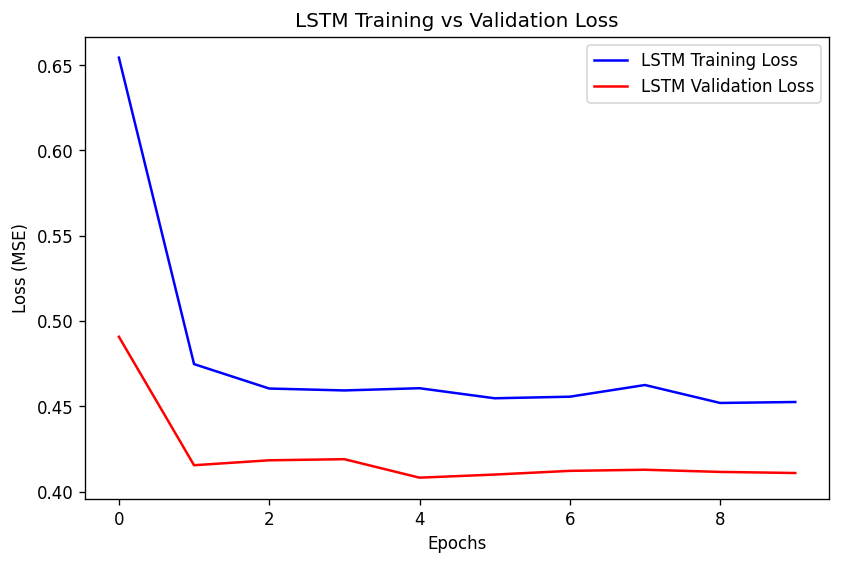

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(history_uni.history['loss'], label='LSTM Training Loss', color='blue')
plt.plot(history_uni.history['val_loss'], label='LSTM Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.show()

From the plot we can see how well our model is fitting to the training data. This plot suggests that our LSTM model is training well without overfitting. The early drop in loss and stabilization afterward confirms convergence and using early stopping helped us prevent unnecessary training.

In [28]:
y_pred_uni = model_uni.predict(scaled_uni_val_X)
y_pred_uni = y_pred_uni.flatten()

mse_uni = mean_squared_error(scaled_uni_val_y, y_pred_uni)
rmse_uni = np.sqrt(mse_uni)
r2_uni = r2_score(scaled_uni_val_y, y_pred_uni)
mape_uni = np.mean(np.abs((scaled_uni_val_y - y_pred_uni) / scaled_uni_val_y)) * 100

print(f"MSE: {mse_uni:.4f}")
print(f"RMSE: {rmse_uni:.4f}")
print(f" R² Score: {r2_uni:.4f}")
print(f"MAPE: {mape_uni:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 0.4082
RMSE: 0.6389
 R² Score: 0.5983
MAPE: 126.3401


The univariate LSTM model gives an MSE of 0.4082 and an R² of 0.5983 on the validation set, it means a good performance on training dataset. The RMSE and MAPE also shows that while predictions are generally close to actual values, there is a space for improvement in reducing relative error.

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


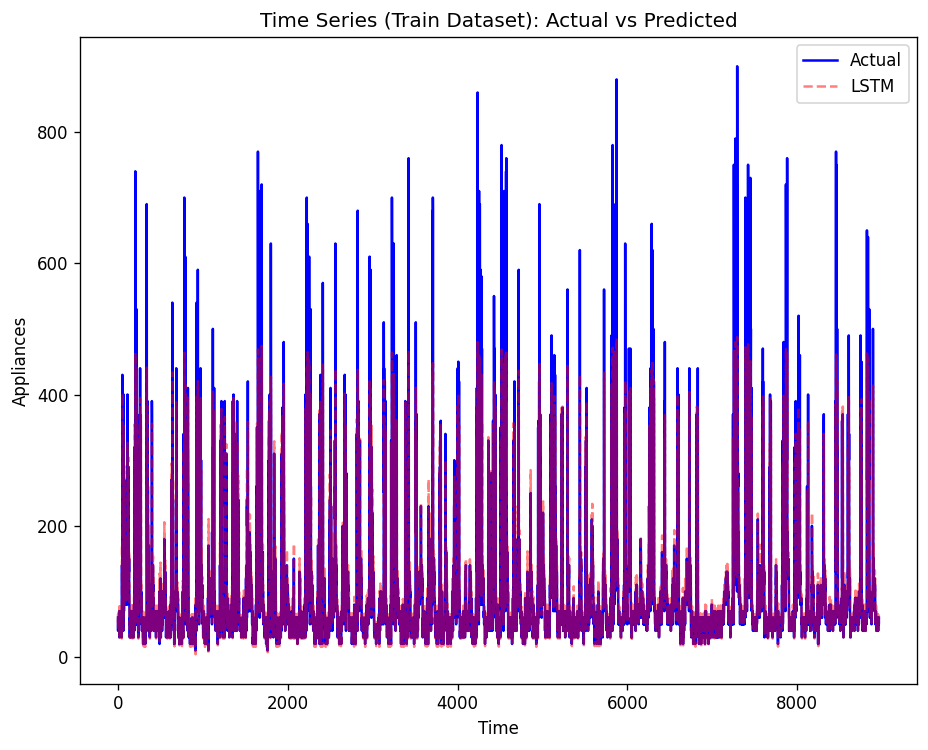

In [29]:
unscaled_uni = scaler_uni.inverse_transform(scaled_uni_train_y.reshape(-1, 1))
unscaled_pred_lstm_train_uni = scaler_uni.inverse_transform(model_uni.predict(scaled_uni_train_X).reshape(-1, 1))

plt.plot(unscaled_uni, 'b', label='Actual')
plt.plot(unscaled_pred_lstm_train_uni, 'r', label='LSTM', alpha=0.5, linestyle='--')
plt.title('Time Series (Train Dataset): Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Appliances')
plt.legend()
plt.show()

From the plot, it seems that the univariate LSTM predicts the values in training dataset pretty will.

#### 4.1.2 Multivariate

In [30]:
input_shape_multi = (scaled_multi_train_X.shape[1], scaled_multi_train_X.shape[2])


tuner_multi = kt.BayesianOptimization(
    lambda hp: lstm_model(hp, input_shape_multi),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='lstm_multivariate'
)

tuner_multi.search(scaled_multi_train_X, scaled_multi_train_y,
                   validation_data=(scaled_multi_val_X, scaled_multi_val_y),
                   epochs=epochs, batch_size=batch_size)

best_hp_multi = tuner_multi.get_best_hyperparameters(num_trials=1)[0]

model_multi = lstm_model(best_hp_multi, input_shape_multi)

history_multi = model_multi.fit(
    scaled_multi_train_X, scaled_multi_train_y,
    validation_data=(scaled_multi_val_X, scaled_multi_val_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stop]
)

Reloading Tuner from tuner_results/lstm_multivariate/tuner0.json
Epoch 1/50


/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9761 - val_loss: 0.9148
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8094 - val_loss: 0.9545
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7449 - val_loss: 1.0094
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7922 - val_loss: 1.0333
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7525 - val_loss: 1.1352


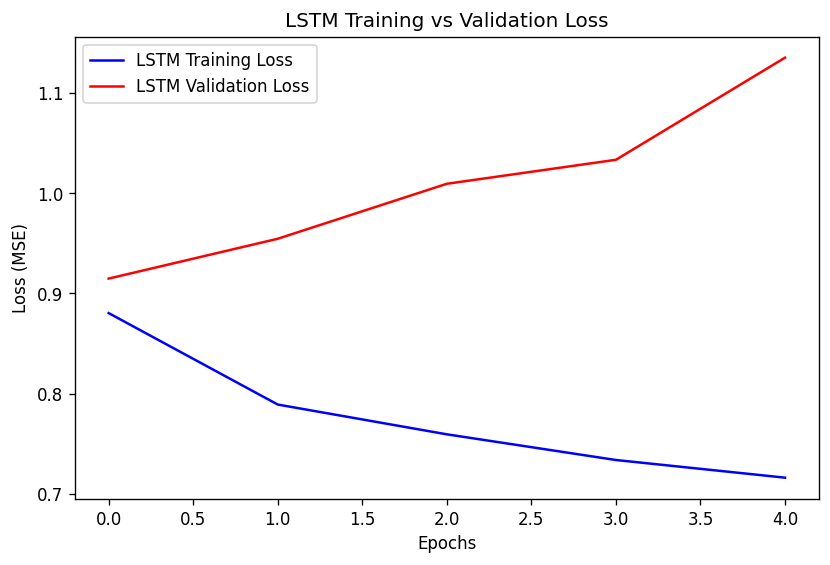

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(history_multi.history['loss'], label='LSTM Training Loss', color='blue')
plt.plot(history_multi.history['val_loss'], label='LSTM Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.show()

The plot shows the training loss decreased consistently but the validation loss began to increase gradually after epoch 2, it means the onset of overfitting. This plot looks not good for preventing overfitting.

In [32]:
y_pred_multi = model_multi.predict(scaled_multi_val_X)
y_pred_multi = y_pred_multi.flatten()

mse_multi = mean_squared_error(scaled_multi_val_y, y_pred_multi)
rmse_multi = np.sqrt(mse_multi)
r2_multi = r2_score(scaled_multi_val_y, y_pred_multi)
mape_multi = np.mean(np.abs((scaled_multi_val_y - y_pred_multi) / scaled_multi_val_y)) * 100

print(f"MSE: {mse_multi:.4f}")
print(f"RMSE: {rmse_multi:.4f}")
print(f" R² Score: {r2_multi:.4f}")
print(f"MAPE: {mape_multi:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.9148
RMSE: 0.9564
 R² Score: 0.0999
MAPE: 149.6957


This results mean while the model learned during training, it struggled to generalize on the validation set. The performance decreasea from training to validation also contains a possible for overfitting or the selected features do not capture the dynamics of the target variable well enough.

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


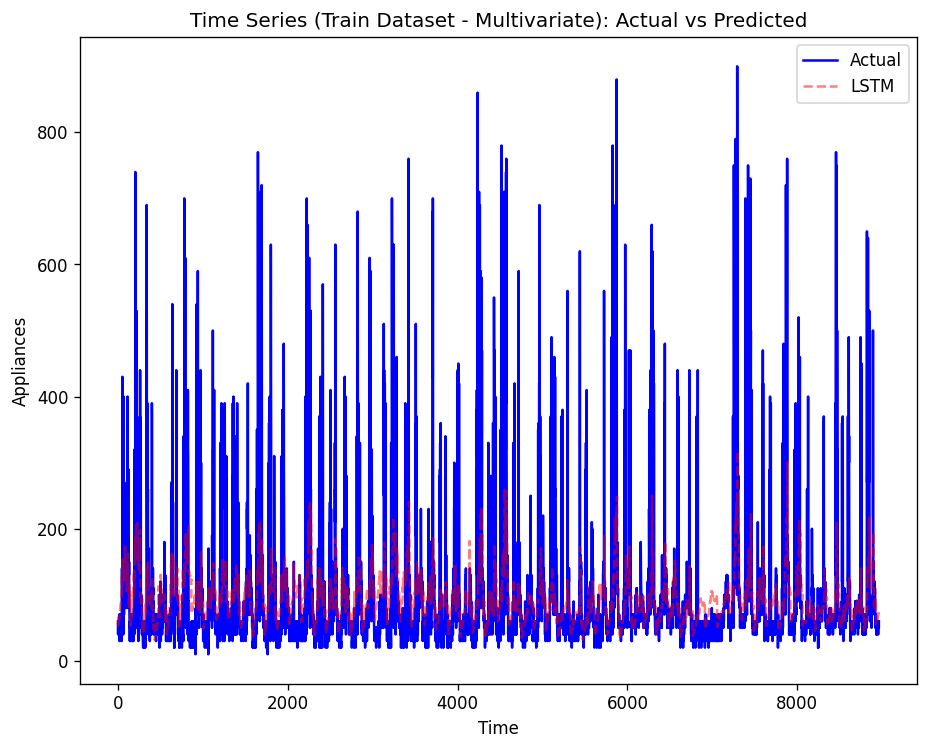

In [33]:
appliances_index = multivariate_train.columns.get_loc('Appliances')
unscaled_multi_y = scaler.inverse_transform(
    np.hstack([np.zeros((scaled_multi_train_y.shape[0], appliances_index)),
               scaled_multi_train_y.reshape(-1, 1),
               np.zeros((scaled_multi_train_y.shape[0], len(multivariate_train.columns) - appliances_index - 1))])
)[:, appliances_index]

unscaled_pred_lstm_multi = scaler.inverse_transform(
    np.hstack([np.zeros((scaled_multi_train_X.shape[0], appliances_index)),
               model_multi.predict(scaled_multi_train_X).reshape(-1, 1),
               np.zeros((scaled_multi_train_X.shape[0], len(multivariate_train.columns) - appliances_index - 1))])
)[:, appliances_index]

# Plotting
plt.plot(unscaled_multi_y, 'b', label='Actual')
plt.plot(unscaled_pred_lstm_multi, 'r--', label='LSTM', alpha=0.5)
plt.title('Time Series (Train Dataset - Multivariate): Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Appliances')
plt.legend()
plt.show()

The result of this plot shows the bad performance for forcasting the values.

#### 4.2 ARIMA model

In [34]:
from statsmodels.tsa.arima.model import ARIMA

#### 4.2.1 ARIMA

From data analysis part we decided we will use 1st order differencing, 10th for AR lag, and 3rd order for MA lag. Since we didn't find the seasonality from data analysis part, we use simaple ARIMA rather SARIMA to be the model

In [35]:
order = (10, 1, 3)

# Combining univariate_train and univariate_val
univariate_main = pd.concat([univariate_train, univariate_val])

arima_model = ARIMA(univariate_main, order=order, trend='n')
result_arima = arima_model.fit()

forecast_steps = len(univariate_test)
forecast_arima = result_arima.forecast(steps=forecast_steps)

print(result_arima.summary())

/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             Appliances   No. Observations:                11205
Model:                ARIMA(10, 1, 3)   Log Likelihood              -62688.780
Date:                Sun, 23 Mar 2025   AIC                         125405.560
Time:                        22:43:30   BIC                         125508.097
Sample:                             0   HQIC                        125440.073
                              - 11205                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1537      0.044      3.493      0.000       0.067       0.240
ar.L2          0.6583      0.029     22.814      0.000       0.602       0.715
ar.L3         -0.2822      0.026    -10.662      0.0

In [36]:
print(f"AIC: {result_arima.aic:.3f}, BIC: {result_arima.bic:.3f}")

AIC: 125405.560, BIC: 125508.097


In [37]:
arima_pred_test = result_arima.forecast(steps=len(univariate_test))

y_test_flat = univariate_test.values.flatten()
arima_pred_test = arima_pred_test.values.flatten()

mse_arima = mean_squared_error(y_test_flat, arima_pred_test)
rmse_arima = np.sqrt(mse_arima)
r2_arima = r2_score(y_test_flat, arima_pred_test)
mape_arima = np.mean(np.abs((y_test_flat - arima_pred_test) / y_test_flat)) * 100


# Print performance scores
print(f"MSE: {mse_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"R² Score: {r2_arima:.4f}")
print(f"MAPE: {mape_arima:.4f}")

MSE: 7587.2763
RMSE: 87.1050
R² Score: -0.0099
MAPE: 63.8223


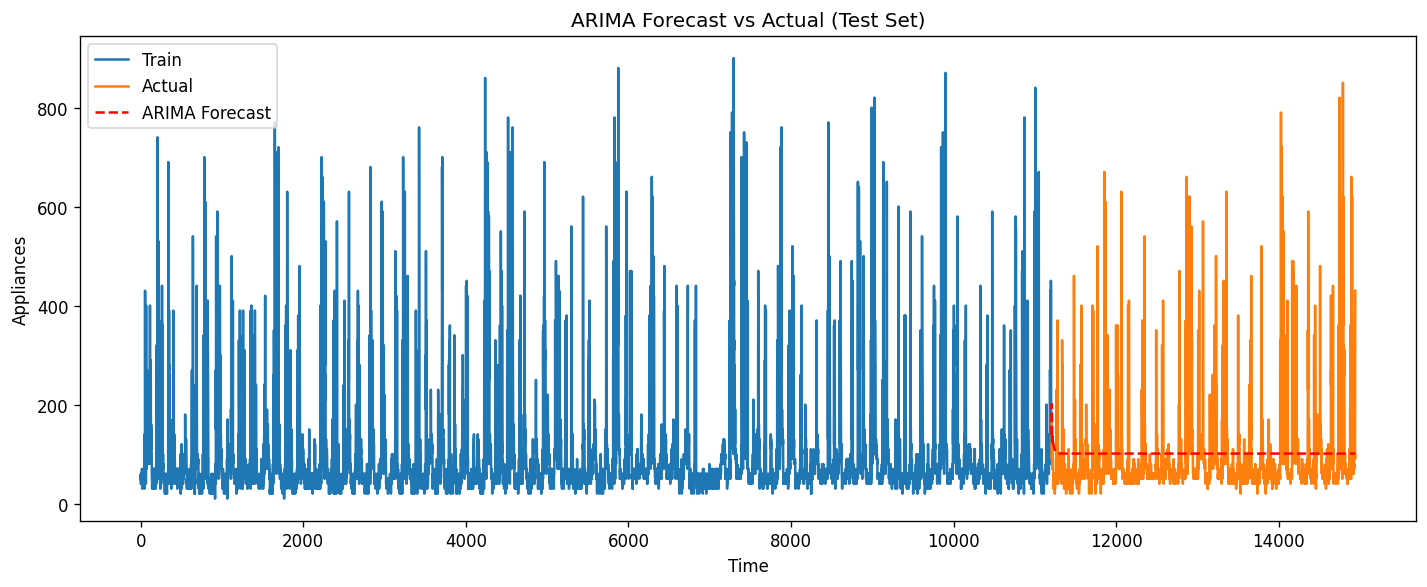

In [38]:
plt.figure(figsize=(12, 5))
plt.plot(univariate_main.index, univariate_main['Appliances'], label='Train')
plt.plot(univariate_test.index, univariate_test['Appliances'], label='Actual')
plt.plot(univariate_test.index, forecast_arima, label='ARIMA Forecast', linestyle='--', color='red')
plt.title('ARIMA Forecast vs Actual (Test Set)')
plt.xlabel('Time')
plt.ylabel('Appliances')
plt.legend()
plt.tight_layout()
plt.show()

The ARIMA model performance on the test dataset shows a clear limitation in its own ability to capture the complex and highly variable patterns of appliance energy usage. Although ARIMA is effective for simpler, linear, and stationary time series, this dataset likely contains nonlinear dynamics and irregular consumption spikes, which ARIMA struggles to model. The forecast mostly being flat compared to the real sharp fluctuations in the test data, it means that the model fails to respond rapid changes. The negative R² score confirms that the ARIMA predictions are worse than simply using the mean as a baseline. 

#### 4.2.2 Auto-ARIMA

In [39]:
# %pip install pmdarima

from pmdarima import auto_arima

In [40]:
auto_model = auto_arima(univariate_main, start_p=1, start_q=1,
                        test='adf',
                        max_p=3, max_q=3, m=1, d=1,
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True,
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=126011.700, Time=1.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=127619.174, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=127552.213, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=127466.061, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=127617.174, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=125769.446, Time=2.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=126772.218, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=125736.549, Time=4.95 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=126502.341, Time=0.51 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=125737.831, Time=7.98 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=125742.077, Time=3.29 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=125734.558, Time=0.99 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=125767.453, Time=0.69 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=126500.341, Time=0.25 sec
 ARIM

In [41]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11205
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -62862.279
Date:                Sun, 23 Mar 2025   AIC                         125734.558
Time:                        22:43:58   BIC                         125771.178
Sample:                             0   HQIC                        125746.884
                              - 11205                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6897      0.007     99.657      0.000       0.676       0.703
ar.L2         -0.1927      0.006    -32.236      0.000      -0.204      -0.181
ar.L3          0.0660      0.007     10.022      0.000       0.053       0.079
ma.L1         -0.9075      0.005   -182.382      0.000      -0.917      -0.898
sigma2      4374.1177     17.630    248.113      0.000    4339.564    4408.671
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            248035.68
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             3.14
Prob(H) (two-sided):                  0.01   Kurtosis:                        25.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
auto_pred_test = auto_model.predict(n_periods=len(univariate_test))

y_test_flat = univariate_test['Appliances'].values.flatten()

mse_auto = mean_squared_error(y_test_flat, auto_pred_test)
rmse_auto = np.sqrt(mse_auto)
r2_auto = r2_score(y_test_flat, auto_pred_test)
mape_auto = np.mean(np.abs((y_test_flat - auto_pred_test) / y_test_flat)) * 100

print(f"MSE: {mse_auto:.4f}")
print(f"RMSE: {rmse_auto:.4f}")
print(f"R² Score: {r2_auto:.4f}")
print(f"MAPE: {mape_auto:.4f}")

MSE: 16956.7008
RMSE: 130.2179
R² Score: -1.2570
MAPE: 186.1674


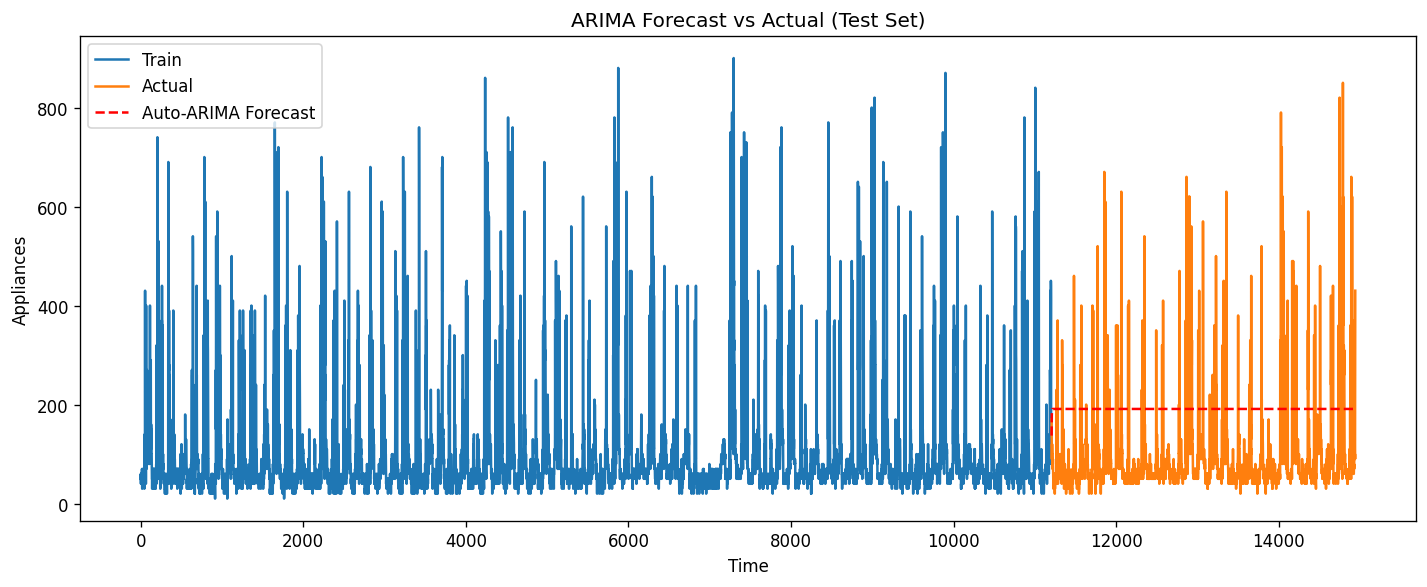

In [43]:
plt.figure(figsize=(12, 5))
plt.plot(univariate_main.index, univariate_main, label='Train')
plt.plot(univariate_test.index, univariate_test, label='Actual')
plt.plot(univariate_test.index, auto_pred_test, label='Auto-ARIMA Forecast', linestyle='--', color='red')
plt.title('ARIMA Forecast vs Actual (Test Set)')
plt.xlabel('Time')
plt.ylabel('Appliances')
plt.legend()
plt.tight_layout()
plt.show()

The Auto-ARIMA model is define to automatically determine the best parameters for this time series, but the results remain unsatisfactory even worse than manual ARIMA. While it simplifies the model selection process, its predictions on the test data are overly smoothed and fail to track the sharp, frequent spikes in appliance energy usage. 

### 5. Testing and analysis of the final model


From this part we only implement by LSTM model because we already did the testing dataset for ARIMA models. Here we will re-train the model by 75% of data and using testing dataset to predict the final results.

#### 5.1 LSTM model

#### 5.1.1 Univariate

In [44]:
scaled_uni_main = np.concatenate([scaled_uni_train, scaled_uni_val])
scaled_uni_main_X, scaled_uni_main_y = to_sequence(scaled_uni_main, seq_len=2, is_univariate=True)

input_shape_uni = (scaled_uni_main_X.shape[1], 1)

model_final_uni = lstm_model(best_hp_uni, input_shape_uni)

history_final_uni = model_final_uni.fit(
    scaled_uni_main_X, scaled_uni_main_y,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7488
Epoch 2/50
 89/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4236

/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4375
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4942
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4285
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4259
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4924
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4299
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4279
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4707
Epoch 10/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4445
Epoch 11/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4586
Epoch 12/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4340
Epoch 13/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4894
Epoch 14/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4427
Epoch 15/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4540
Epoch 16/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4890

In [45]:
y_pred_uni = model_final_uni.predict(scaled_uni_test_X)
y_pred_uni = y_pred_uni.flatten()

mse_uni = mean_squared_error(scaled_uni_test_y, y_pred_uni)
rmse_uni = np.sqrt(mse_uni)
r2_uni = r2_score(scaled_uni_test_y, y_pred_uni)
mape_uni = np.mean(np.abs((scaled_uni_test_y - y_pred_uni) / scaled_uni_test_y)) * 100

print(f"MSE: {mse_uni:.4f}")
print(f"RMSE: {rmse_uni:.4f}")
print(f" R² Score: {r2_uni:.4f}")
print(f"MAPE: {mape_uni:.4f}")


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.3275
RMSE: 0.5722
 R² Score: 0.5607
MAPE: 118.0938


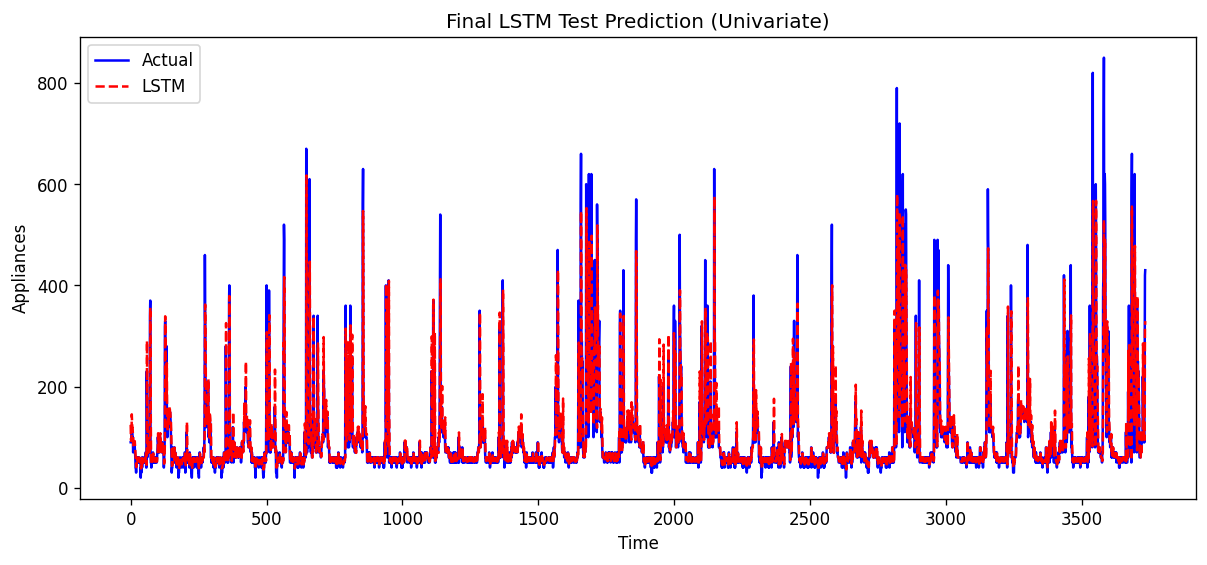

In [46]:
y_true_final_uni_test_unscaled = scaler_uni.inverse_transform(scaled_uni_test_y.reshape(-1, 1)).flatten()
y_pred_final_uni_test_unscaled = scaler_uni.inverse_transform(y_pred_uni.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_true_final_uni_test_unscaled, label="Actual", color='blue')
plt.plot(y_pred_final_uni_test_unscaled, label="LSTM", color='red', linestyle='--')
plt.title("Final LSTM Test Prediction (Univariate)")
plt.xlabel("Time")
plt.ylabel("Appliances")
plt.legend()
plt.show()

The final results of univariate LSTM perform well, which means the model predicts the values in the training dataset well. But this makes sense since the final performance is slightly weaker than training part. This difference may be due to the increased volatility and noise in the unseen test data, which the model hasn't encountered during training. Since this is a univariate setup using only the Appliances variable, the model might struggle with sharp peaks and sudden changes caused by external factors like human behavior, device usage patterns, or weather — all of them are not captured by the single input. Still, the model manages to follow the general trend and seasonal fluctuations. While it may miss some of the extreme highs or lows, the overall shape and timing of the predictions align closely with the actual values, which indicates the model has learned the underlying structure well despite being a simple univariate configuration.

#### 5.1.2 Multivariate

In [47]:
scaled_multi_main = pd.concat([scaled_train_multi, scaled_val_multi], axis=0).values
scaled_multi_main_X, scaled_multi_main_y = to_sequence(scaled_multi_main, seq_len=2, is_univariate=False)

input_shape_multi = (scaled_multi_main_X.shape[1], scaled_multi_main_X.shape[2])

model_final_multi = lstm_model(best_hp_multi, input_shape_multi)

history_final_multi = model_final_multi.fit(
    scaled_multi_main_X, scaled_multi_main_y,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9639
Epoch 2/50
 97/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7629

/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7880
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7597
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7737
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7684
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6728
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6952
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6903
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7014
Epoch 10/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6742
Epoch 11/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6305
Epoch 12/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7069
Epoch 13/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6769
Epoch 14/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6586
Epoch 15/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6231
Epoch 16/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6130

In [48]:
y_pred_multi = model_final_multi.predict(scaled_multi_test_X)
y_pred_multi = y_pred_multi.flatten()

mse_multi = mean_squared_error(scaled_multi_test_y, y_pred_multi)
rmse_multi = np.sqrt(mse_multi)
r2_multi = r2_score(scaled_multi_test_y, y_pred_multi)
mape_multi = np.mean(np.abs((scaled_multi_test_y - y_pred_multi) / scaled_multi_test_y)) * 100

print(f"MSE: {mse_multi:.4f}")
print(f"RMSE: {rmse_multi:.4f}")
print(f" R² Score: {r2_multi:.4f}")
print(f"MAPE: {mape_multi:.4f}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 1.8605
RMSE: 1.3640
 R² Score: -1.4959
MAPE: 491.3203


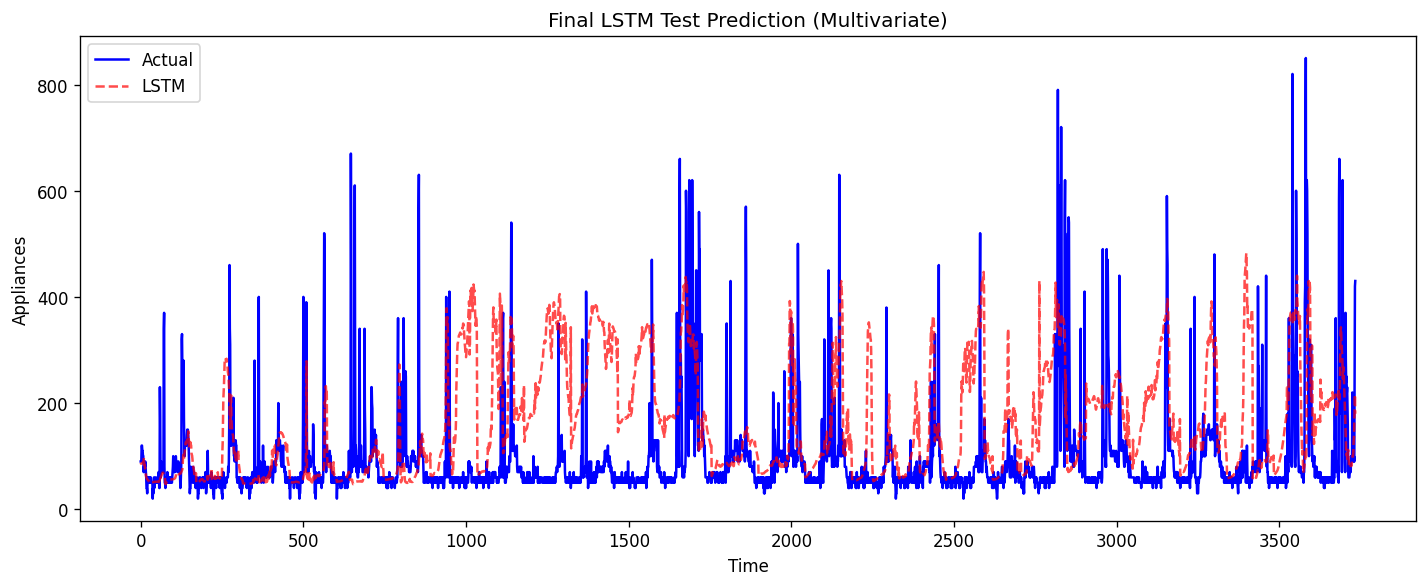

In [49]:
scaler.fit(multivariate_train[['Appliances']])  # Only fit on target column

unscaled_multi_y_test = scaler.inverse_transform(scaled_multi_test_y.reshape(-1, 1))
unscaled_pred_lstm_test_multi = scaler.inverse_transform(y_pred_multi.reshape(-1, 1))

plt.figure(figsize=(12, 5))
plt.plot(unscaled_multi_y_test, label='Actual', color='blue')
plt.plot(unscaled_pred_lstm_test_multi, label='LSTM', linestyle='--', color='red', alpha=0.7)
plt.title('Final LSTM Test Prediction (Multivariate)')
plt.xlabel('Time')
plt.ylabel('Appliances')
plt.legend()
plt.tight_layout()
plt.show()

The final results of the multivariate LSTM model shows that while the model learned some general trends from the data, the testing part performance is significantly weaker than the training part. This might because of the complexity of incorporating many features, which can introduce noise or irrelevant patterns that the model overfits during training. From the previous assignment we also got the bad performance from those features. Although the multivariate approach was expected to improve performance by adding additional features like temperature, wind speed, or humidity, the model may not have fully generalized their interactions with the target variable appliances. The relatively low R² score and high MAPE imply that the model dealing hardly with sharp peaks and outliers. This means a need for either more relevant features or simply more robust feature engineering and tuning. 

#### 5.2 Comparing the results with previous assignment

In [54]:
# Collecting final results from this assignment
results = {
    'Model': ['ARIMA', 'Auto-ARIMA', 'LSTM Univariate', 'LSTM Multivariate'],
    'MSE': [mse_arima, mse_auto, mse_uni, mse_multi],
    'RMSE': [rmse_arima, rmse_auto, rmse_uni, rmse_multi],
    'R²': [r2_arima, r2_auto, r2_uni, r2_multi],
    'MAPE': [mape_arima, mape_auto, mape_uni, mape_multi]
}
# Previous results
results['Model'].extend(['Random Forest', 'lrGAM', 'Linear Regression'])
results['MSE'].extend([39858.51663950852, 30794.9673115018, 6938.372187353724])
results['RMSE'].extend([199.64597827030855, 175.4849489600228, 83.2968918228869])
results['R²'].extend([-4.30529479514049, -3.0989076756632308, 0.07648068829966503])
results['MAPE'].extend([226.89745265848748, 186.3080714151547, 55.917244638714294])
# Creating a DataFrame to display the results
results_df = pd.DataFrame(results)
# Displaying the results as columns
results_df = results_df.set_index('Model').T
print(results_df)

Model        ARIMA    Auto-ARIMA  LSTM Univariate  LSTM Multivariate  \
MSE    7587.276259  16956.700844         0.327462           1.860507   
RMSE     87.104973    130.217898         0.572243           1.364004   
R²       -0.009890     -1.256991         0.560707          -1.495889   
MAPE     63.822288    186.167359       118.093827         491.320317   

Model  Random Forest         lrGAM  Linear Regression  
MSE     39858.516640  30794.967312        6938.372187  
RMSE      199.645978    175.484949          83.296892  
R²         -4.305295     -3.098908           0.076481  
MAPE      226.897453    186.308071          55.917245  


Time-series models(ARIMA, Auto-ARIMA, and LSTM) are specifically designed to capture temporal dependencies. LSTM (Univariate) performs the best, it uses sequential patterns to achieve the lowest error. By the contrast, non-time-series models(Linear Regression,Random Forest, and GAM) fail to account for time-based structures, resulting in poor generalization and high error rates. Interestly, many models performance are much weaker than Linear model, which is the simpliest model among them. Shows the huge space improvement like higher correlation feature picking, model motifying, and more complicated models.

### 6. Reflection

I do simple RNN first and I found that I should also split train/validation data as assignment 1. For version 2, I found that I need to do more data analysis for my models, seems like there are some issues on models. And I also change the time series to 10 minutes to see if models can find patterns easier than unit of day. For version 3, I tried to use the features that I picked in assignment 1 but it seems the model didn't fit well and also performing like linear line. It mea ns there are some issues with my models. For version 4 I will add new features and do some improvements. Also do some different way to the model. I use MinMax scaler to be the scaler first but it performs not as predicted, thus I decided to use basic scaler Standardscaler. And also I did huge change for pre-processing part, it becomes more easier to fit the models. For EDA, I also add some visualization to decide the parameters we used in ARIMA. 

On this project, I learned the past values can really forecast the future values. Although those models performs not well as expected, it shows the potential of forecast power. From the data analysis part, I learned how to find the best parameters for the model and also how to implement the knowledge from the paper. Those models could be enhanced a lot by enough time and resources. Like seasonality of ARIMA, improving LSTM models by selecting higher correlation features. For the multivariate LSTM, I surprised that since I used early stopping and dropout rate to prevent overfitting. However, the result of the training/validation loss still goes bad. In the future, we can use other time-series models to improve the result.

### 7. References

1. (Candanedo, LM, Feldheim, V & Deramaix, D 2017, 'Data driven prediction models of energy use of appliances in a low-energy house', Energy and buildings, vol. 140, pp. 81-97.)

2. S. Siami-Namini, N. Tavakoli and A. Siami Namin, "A Comparison of ARIMA and LSTM in Forecasting Time Series," 2018 17th IEEE International Conference on Machine Learning and Applications (ICMLA), Orlando, FL, USA, 2018, pp. 1394-1401, doi: 10.1109/ICMLA.2018.00227.

### 8. Appendix